# Fine tuning classification with OpenAI

We will fine-tune an ada classifier to classify the number of stars a reviewer will give an item

In [2]:
import pandas as pd
import openai
import os
from datasets import load_dataset
import random
import math

openai.api_key = os.getenv("OPENAI_API_KEY")

random.seed(42)
dataset = load_dataset("amazon_reviews_multi", "all_languages")

Found cached dataset amazon_reviews_multi (/Users/sinanozdemir/.cache/huggingface/datasets/amazon_reviews_multi/all_languages/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 1200000
    })
    validation: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 30000
    })
    test: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 30000
    })
})

In [34]:
# convert to pandas dataframe
training_df = pd.DataFrame(dataset['train'])

training_df.head()

review_id          product_id          reviewer_id  stars  \
0  de_0203609  product_de_0865382  reviewer_de_0267719      1   
1  de_0559494  product_de_0678997  reviewer_de_0783625      1   
2  de_0238777  product_de_0372235  reviewer_de_0911426      1   
3  de_0477884  product_de_0719501  reviewer_de_0836478      1   
4  de_0270868  product_de_0022613  reviewer_de_0736276      1   

                                         review_body  \
0     Armband ist leider nach 1 Jahr kaputt gegangen   
1                 In der Lieferung war nur Ein Akku!   
2  Ein Stern, weil gar keine geht nicht. Es hande...   
3  Dachte, das wären einfach etwas festere Binden...   
4  Meine Kinder haben kaum damit gespielt und nac...   

                review_title language  product_category  
0  Leider nach 1 Jahr kaputt       de            sports  
1   EINS statt ZWEI Akkus!!!       de  home_improvement  
2            Achtung Abzocke       de         drugstore  
3          Zu viel des Guten       de         drugstore  
4     Qualität sehr schlecht       de               toy

In [35]:
val_df = pd.DataFrame(dataset['validation'])

In [36]:
training_df[['review_title', 'review_body', 'stars']].sample(5)

review_title  \
486214            Irriagador   
175470  Einfach hervorragend   
275150               Too big   
614474             Camelotte   
192026   Schönes Nachtlicht!   

                                              review_body  stars  
486214                         Este producto es muy bueno      3  
175470  Trage sie an kalten Tagen ständig und bin über...      5  
275150  This case is huge! The size of a small backpac...      2  
614474  Le minuteur est très mignon mais il s'est cass...      1  
192026  Dieses Nachtlicht zaubert einen tollen Sternen...      5

In [37]:
english_training_df = training_df[training_df['language'] == 'en']
english_val_df = val_df[training_df['language'] == 'en']

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_19225/4004535716.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  english_val_df = val_df[training_df['language'] == 'en']


In [49]:
test_df = pd.DataFrame(dataset['test'])
english_test_df = test_df[test_df['language'] == 'en']

# Star prediction (sentiment)

In [ ]:
'312'  # '1' is a token
'I am number 1'  # ' 1' is a token

In [38]:
english_training_df['prompt'] = english_training_df['review_title'] + '\n\n' + english_training_df['review_body'] + '\n\n###\n\n'
english_val_df['prompt'] = english_val_df['review_title'] + '\n\n' + english_val_df['review_body'] + '\n\n###\n\n'

english_training_df['completion'] = ' ' + english_training_df['stars'].astype(str)  # for sentiment
english_val_df['completion'] = ' ' + english_val_df['stars'].astype(str)  # for sentiment

# drop duplicates
english_training_df.sample(
    len(english_training_df)
).drop_duplicates(subset=['prompt'])[['prompt', 'completion']].to_json(
    "amazon-english-full-train-sentiment-random.jsonl", orient='records', lines=True
)

english_val_df.sample(
    len(english_val_df)
).drop_duplicates(subset=['prompt'])[['prompt', 'completion']].to_json(
    "amazon-english-full-val-sentiment-random.jsonl", orient='records', lines=True
)


/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_19225/2710887141.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_training_df['prompt'] = english_training_df['review_title'] + '\n\n' + english_training_df['review_body'] + '\n\n###\n\n'
/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_19225/2710887141.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_training_df['completion'] = ' ' + english_training_df['stars'].astype(str)  # for sentiment


In [44]:
print(english_training_df['prompt'].iloc[0])

I'll spend twice the amount of time boxing up the whole useless thing and send it back with a 1-star review ...

Arrived broken. Manufacturer defect. Two of the legs of the base were not completely formed, so there was no way to insert the casters. I unpackaged the entire chair and hardware before noticing this. So, I'll spend twice the amount of time boxing up the whole useless thing and send it back with a 1-star review of part of a chair I never got to sit in. I will go so far as to include a picture of what their injection molding and quality assurance process missed though. I will be hesitant to buy again. It makes me wonder if there aren't missing structures and supports that don't impede the assembly process.

###




In [48]:
english_training_df['stars'].iloc[0]

1

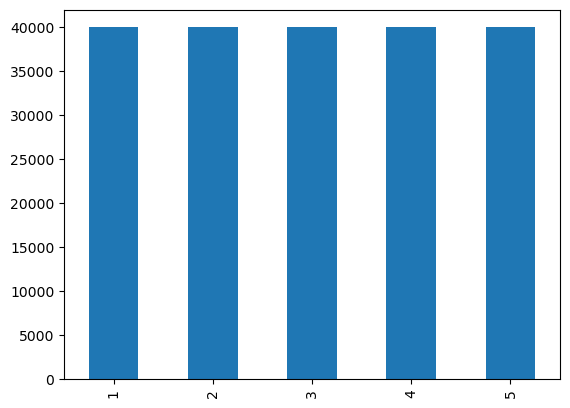

In [39]:
english_training_df['stars'].value_counts().plot(kind='bar')

In [42]:
!openai tools fine_tunes.prepare_data -f amazon-english-full-train-sentiment-random.jsonl

Analyzing...

- Your file contains 199891 prompt-completion pairs
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- All prompts end with suffix `\n\n###\n\n`

No remediations found.
- [Recommended] Would you like to split into training and validation set? [Y/n]: ^C



In [ ]:
!openai api fine_tunes.create -t "amazon-english-full-train-sentiment-random.jsonl" -v "amazon-english-full-val-sentiment-random.jsonl" --compute_classification_metrics --classification_n_classes 5 -m ada --n_epochs 1


In [74]:
!openai api fine_tunes.follow -i ft-tnvysbOzvkIfPgtPo6oQ3c7O

[2023-05-08 08:51:29] Created fine-tune: ft-tnvysbOzvkIfPgtPo6oQ3c7O
[2023-05-08 08:53:19] Fine-tune costs $4.26
[2023-05-08 08:53:19] Fine-tune enqueued. Queue number: 2
[2023-05-08 08:56:21] Fine-tune is in the queue. Queue number: 1
[2023-05-08 08:57:30] Fine-tune is in the queue. Queue number: 0
[2023-05-08 08:59:17] Fine-tune started
[2023-05-08 09:23:11] Completed epoch 1/1
[2023-05-08 09:25:48] Uploaded model: ada:ft-personal-2023-05-08-16-25-48
[2023-05-08 09:25:49] Uploaded result file: file-QHhhi05wgj0eBQGnpPLxXBaT
[2023-05-08 09:25:49] Fine-tune succeeded

Job complete! Status: succeeded 🎉
Try out your fine-tuned model:

openai api completions.create -m ada:ft-personal-2023-05-08-16-25-48 -p <YOUR_PROMPT>


In [78]:
!openai wandb sync -i ft-tnvysbOzvkIfPgtPo6oQ3c7O


wandb: Currently logged in as: profoz. Use `wandb login --relogin` to force relogin
Fine-tune ft-tnvysbOzvkIfPgtPo6oQ3c7O has already been logged successfully at https://wandb.ai/profoz/GPT-3/runs/ft-tnvysbOzvkIfPgtPo6oQ3c7O
A new wandb run will be created for fine-tune ft-tnvysbOzvkIfPgtPo6oQ3c7O and previous run will be overwritten
wandb: Tracking run with wandb version 0.15.7
wandb: Run data is saved locally in /Users/sinanozdemir/Teaching/Pearson/quick-start-llms/notebooks/wandb/run-20230801_071708-ft-tnvysbOzvkIfPgtPo6oQ3c7O
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ft-tnvysbOzvkIfPgtPo6oQ3c7O
wandb: ⭐️ View project at https://wandb.ai/profoz/GPT-3
wandb: 🚀 View run at https://wandb.ai/profoz/GPT-3/runs/ft-tnvysbOzvkIfPgtPo6oQ3c7O
wandb: Waiting for W&B process to finish... (success).
wandb: \ 0.001 MB of 0.006 MB uploaded (0.000 MB deduped)
wandb: Run history:
wandb:          classification/accuracy ▁
wandb: classification/weighted_f1_score ▁
wandb:      

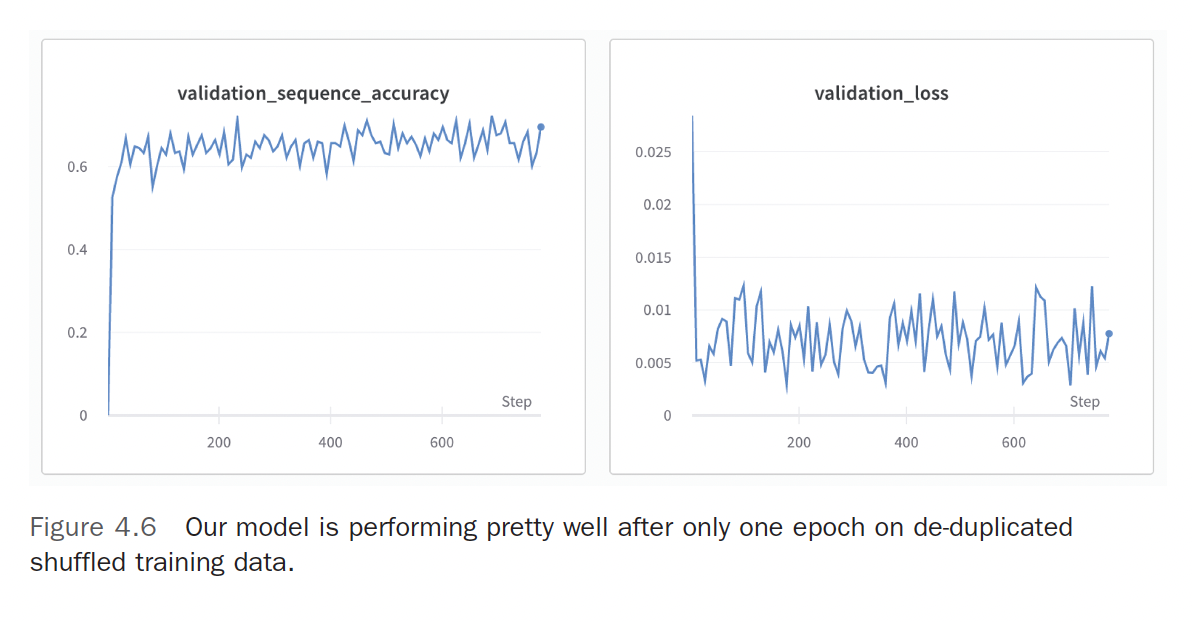

In [ ]:
# further fine-tune for 3 epochs

In [79]:
!openai api fine_tunes.create -t "amazon-english-full-train-sentiment-random.jsonl" -v "amazon-english-full-val-sentiment-random.jsonl" --compute_classification_metrics --classification_n_classes 5 -m ada:ft-personal-2023-05-08-16-25-48 --n_epochs 3


Created fine-tune: ft-BHplF6YKPH80qX5a3UvtULYE
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2023-03-30 21:13:19] Created fine-tune: ft-BHplF6YKPH80qX5a3UvtULYE
[2023-03-30 21:13:58] Fine-tune costs $13.26
[2023-03-30 21:13:58] Fine-tune enqueued. Queue number: 0
[2023-03-30 21:14:02] Fine-tune started

Stream interrupted (client disconnected).
To resume the stream, run:

  openai api fine_tunes.follow -i ft-BHplF6YKPH80qX5a3UvtULYE



In [81]:
!openai api fine_tunes.follow -i ft-BHplF6YKPH80qX5a3UvtULYE

[2023-03-30 21:13:19] Created fine-tune: ft-BHplF6YKPH80qX5a3UvtULYE
[2023-03-30 21:13:58] Fine-tune costs $13.26
[2023-03-30 21:13:58] Fine-tune enqueued. Queue number: 0
[2023-03-30 21:14:02] Fine-tune started
[2023-03-30 21:37:36] Completed epoch 1/3
[2023-03-30 22:28:16] Completed epoch 3/3
[2023-03-30 22:30:47] Uploaded model: ada:ft-personal-2023-03-31-05-30-46
[2023-03-30 22:30:47] Uploaded result file: file-sSdUMHhiNE9j9FCyb2M8Ayjt
[2023-03-30 22:30:48] Fine-tune succeeded

Job complete! Status: succeeded 🎉
Try out your fine-tuned model:

openai api completions.create -m ada:ft-personal-2023-03-31-05-30-46 -p <YOUR_PROMPT>


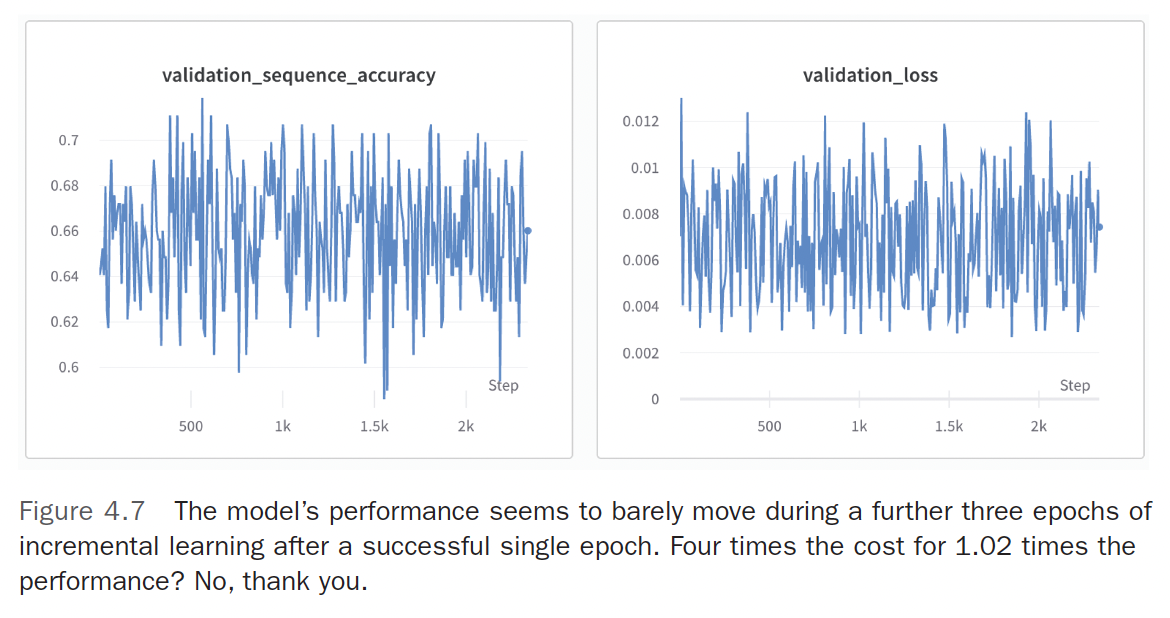

In [50]:
# assume 150/40 ratio from non-finetuned davinci to finetuned ada tokens
# assume 0.0200/0.0016 ratio from non-finetuned davinci to finetuned ada price
# assume 0.0020/0.0016 ratio from non-finetuned chatgpt to finetuned ada price


In [51]:
# assume 4:1 prompt size (conservative and using few shot would be more)

In [52]:
#so for every classification attempt, we pay davinci
nonfinetuned_davinci_classification_unit_cost_in_usd = 160/1000 * .02
nonfinetuned_davinci_classification_unit_cost_in_usd


0.0032

In [53]:
#so for every classification attempt, we pay davinci
nonfinetuned_chatgpt_classification_unit_cost_in_usd = 160/1000 * .002
nonfinetuned_chatgpt_classification_unit_cost_in_usd


0.00032

In [54]:
#so for every classification attempt, we pay fine tuned ada
finetuned_ada_classification_unit_cost_in_usd = 40/1000 * .0016
finetuned_ada_classification_unit_cost_in_usd

6.400000000000001e-05

In [55]:
upfront_ada_cost_in_usd = 4.5 # rounded up for 1 epoch

In [59]:
import numpy as np

cost_projecting_df = pd.DataFrame({
    'classification_count': np.arange(40) * 1000
})

In [79]:
cost_projecting_df['ada_price'] = upfront_ada_cost_in_usd + (finetuned_ada_classification_unit_cost_in_usd * cost_projecting_df['classification_count'])
cost_projecting_df['davinci_price'] =  nonfinetuned_davinci_classification_unit_cost_in_usd * cost_projecting_df['classification_count']
cost_projecting_df['chatgpt_price'] =  nonfinetuned_chatgpt_classification_unit_cost_in_usd * cost_projecting_df['classification_count']


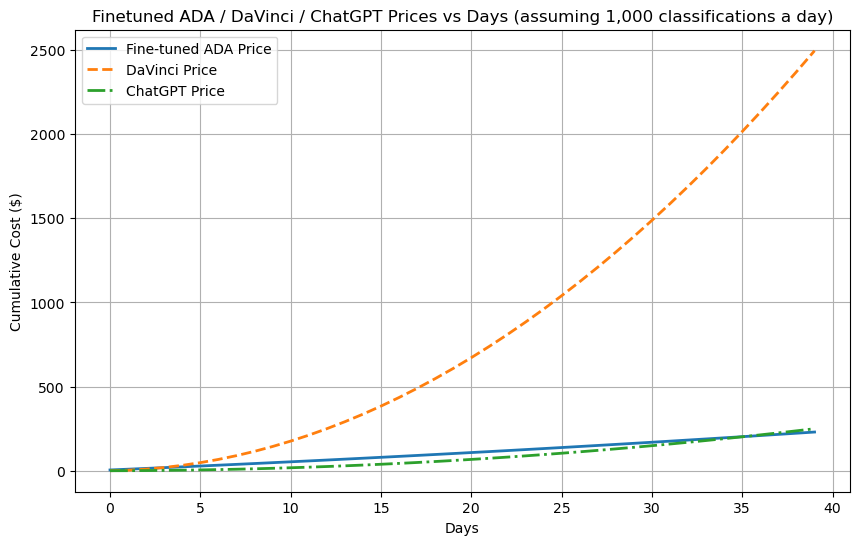

In [61]:
import matplotlib.pyplot as plt

# Increase DPI for a higher-resolution chart
plt.rcParams['figure.dpi'] = 100

plt.figure(figsize=(10, 6))
plt.plot(cost_projecting_df['classification_count']/1000, cost_projecting_df['ada_price'].cumsum(), label='Fine-tuned ADA Price', linestyle='-', linewidth=2)
plt.plot(cost_projecting_df['classification_count']/1000, cost_projecting_df['davinci_price'].cumsum(), label='DaVinci Price', linestyle='--', linewidth=2)
plt.plot(cost_projecting_df['classification_count']/1000, cost_projecting_df['chatgpt_price'].cumsum(), label='ChatGPT Price', linestyle='-.', linewidth=2)

plt.xlabel('Days')
plt.ylabel('Cumulative Cost ($)')
plt.title('Finetuned ADA / DaVinci / ChatGPT Prices vs Days (assuming 1,000 classifications a day)')
plt.legend()
plt.grid()

# Save the figure as a high-resolution PNG file
plt.savefig("price_comparison_chart.png", dpi=300)

plt.show()


In [62]:
english_test_df['completion'] = ' ' + english_test_df['stars'].astype(str)  # for sentiment
english_test_df['prompt'] = english_test_df['review_title'] + '\n\n' + english_test_df['review_body'] + '\n\n###\n\n'


/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_19225/453605618.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_test_df['completion'] = ' ' + english_test_df['stars'].astype(str)  # for sentiment
/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_19225/453605618.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_test_df['prompt'] = english_test_df['review_title'] + '\n\n' + english_test_df['review_body'] + '\n\n###\n\n'


# Evalauting our classifier using test accuracy

In [132]:
correct = 0
stars_preds = []

for i in tqdm(range(english_test_df.shape[0])):
    _pred, _answer, _correct, _probs = classify(
        english_test_df['prompt'].iloc[i], 
        'ada:ft-personal-2023-05-08-16-25-48', 
        english_test_df['stars'].iloc[i]
    )
    correct += _correct
    stars_preds.append(_pred)
accuracy = correct / ( i + 1 )
accuracy

100%|██████████████████████████████████████████████████████████████████████| 5000/5000 [12:10<00:00,  6.85it/s]


0.6308

In [ ]:
# Get our accuracy of the model trained for 1 epoch on shuffled data

In [143]:
(np.array(stars_preds).astype(int) == english_test_df['stars'].astype(int)).mean()

0.6308

In [144]:
# < 3 accuracy
((np.array(stars_preds).astype(int) <= 3) == (english_test_df['stars'].astype(int) <= 3)).mean()

0.9186

In [155]:
# Accuracy (off-by-1)
((np.array(stars_preds).astype(int) - english_test_df['stars'].astype(int)).abs() <= 1).mean()

0.93

In [ ]:
# comparing against the model that was trained on unshuffled data

In [318]:
correct = 0
unshuffled_preds = []

for i in tqdm(range(english_test_df.shape[0])):
    _pred, _answer, _correct, _probs = classify(
        english_test_df['prompt'].iloc[i], 
        'ada:ft-personal-2023-03-30-20-17-51',
        str(english_test_df['stars'].iloc[i])
    )
    
    correct += _correct
    unshuffled_preds.append(_pred)
    if _pred not in '12345':
        print(english_test_df['prompt'].iloc[i])
        break
accuracy = correct / ( i + 1 )
accuracy

100%|██████████████████████████████████████████████████████████████████████| 5000/5000 [15:34<00:00,  5.35it/s]


0.3188

In [319]:
print((np.array(unshuffled_preds).astype(int) == english_test_df['stars'].astype(int)).mean())

# < 3 accuracy
print(((np.array(unshuffled_preds).astype(int) <= 3) == (english_test_df['stars'].astype(int) <= 3)).mean())

# Accuracy (off-by-1)
print(((np.array(unshuffled_preds).astype(int) - english_test_df['stars'].astype(int)).abs() <= 1).mean())

0.3188
0.7032
0.7142


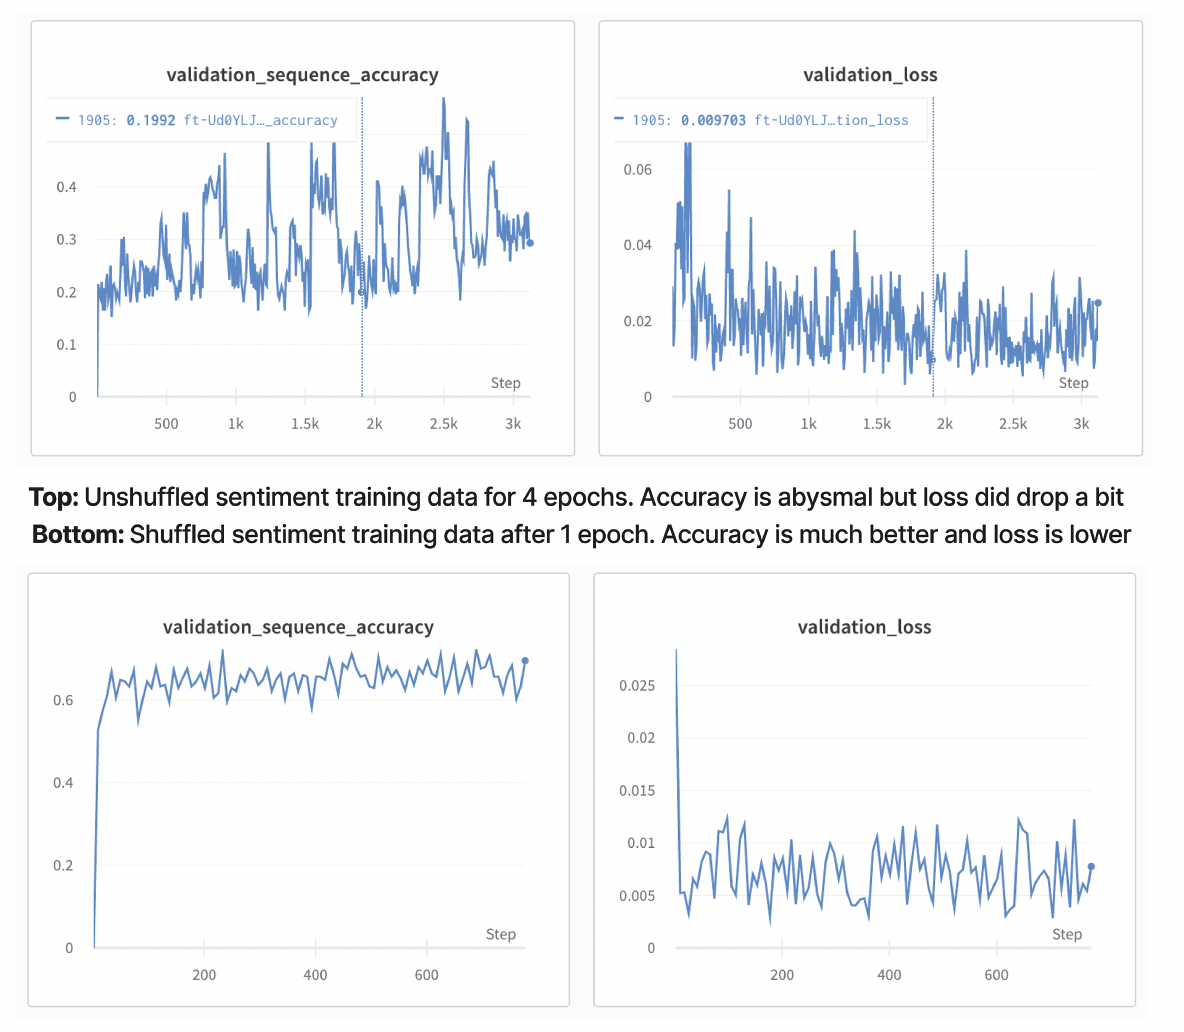

In [ ]:
# This model was trained on the shuffled data for  a total of 4 epochs

In [157]:
converted_preds = []
for pred in four_epoch_stars_preds:
    if pred in ('1', '2', '3', '4', '5'):
        converted_preds.append(int(pred))
    else:
        converted_preds.append(-1)


In [158]:
(np.array(converted_preds).astype(int) == english_test_df['stars'].astype(int)).mean()

0.6378

In [159]:
((np.array(converted_preds).astype(int) <= 3) == (english_test_df['stars'].astype(int) <= 3)).mean()

0.9168

In [160]:
# Accuracy (off-by-1)
((np.array(converted_preds).astype(int) - english_test_df['stars'].astype(int)).abs() <= 1).mean()

0.9298

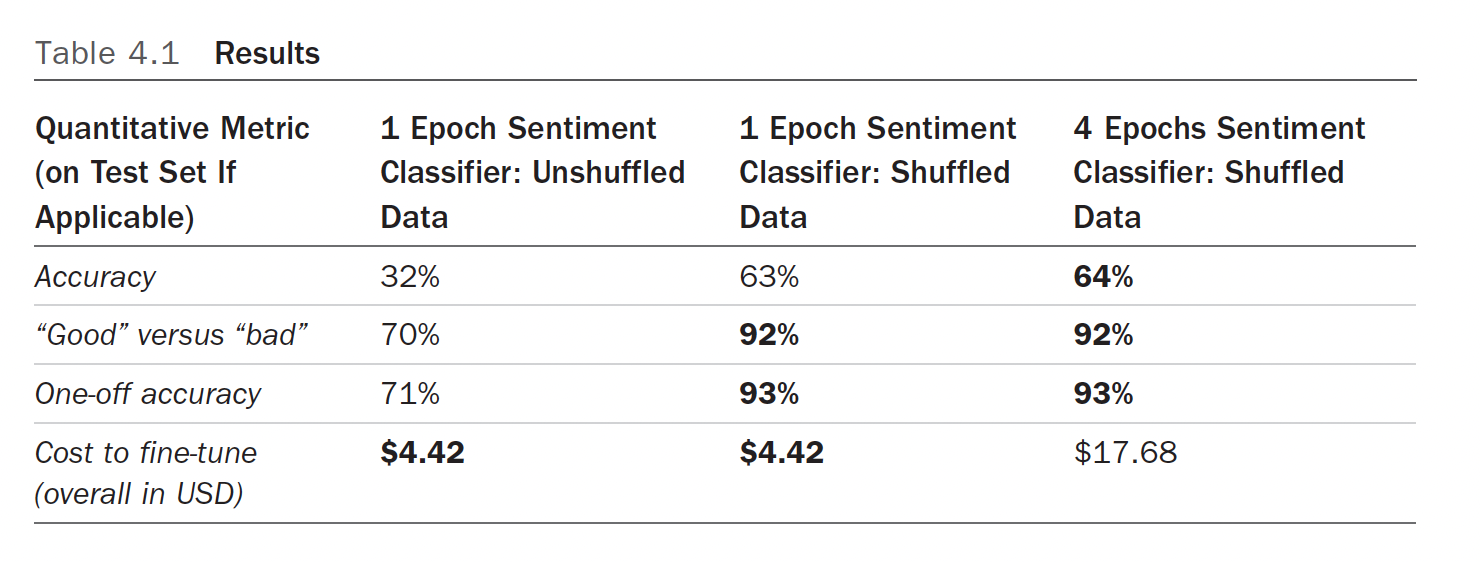

# Using our model

In [72]:
import math

# Select a random prompt from the test dataset
prompt = english_test_df['prompt'].sample(1).iloc[0]

# Generate a completion using the fine-tuned model
res = openai.Completion.create(
    model='ada:ft-personal-2023-05-08-16-25-48', 
    prompt=prompt,
    max_tokens=1, 
    temperature=0, 
    logprobs=5,
)

# Initialize an empty list to store probabilities
probs = []

# Extract logprobs from the API response
logprobs = res['choices'][0]['logprobs']['top_logprobs']

# Convert logprobs to probabilities and store them in the 'probs' list
for logprob in logprobs:
    _probs = {}
    for key, value in logprob.items():
        _probs[key] = math.exp(value)
    probs.append(_probs)

# Extract the predicted category from the API response
pred = res['choices'][0].text.strip()

# Nicely print the prompt, predicted category, and probabilities
print("Prompt: \n", prompt[:-1])
print("Predicted Category:", pred)
print("Probabilities:")
for prob in probs:
    for key, value in sorted(prob.items(), key=lambda x: x[1], reverse=True):
        print(f"{key}: {value:.4f}")
    print()


Prompt: 
 Interesting!!

I really enjoyed this story. I hate nothing was resolved in this book. I look forward to diving into part 2 so I can get my questions answered. Kudos to the author for keeping me engaged.

###

Predicted Category: 4
Probabilities:
 4: 0.7202
 5: 0.2186
 3: 0.0583
 2: 0.0024
 1: 0.0003



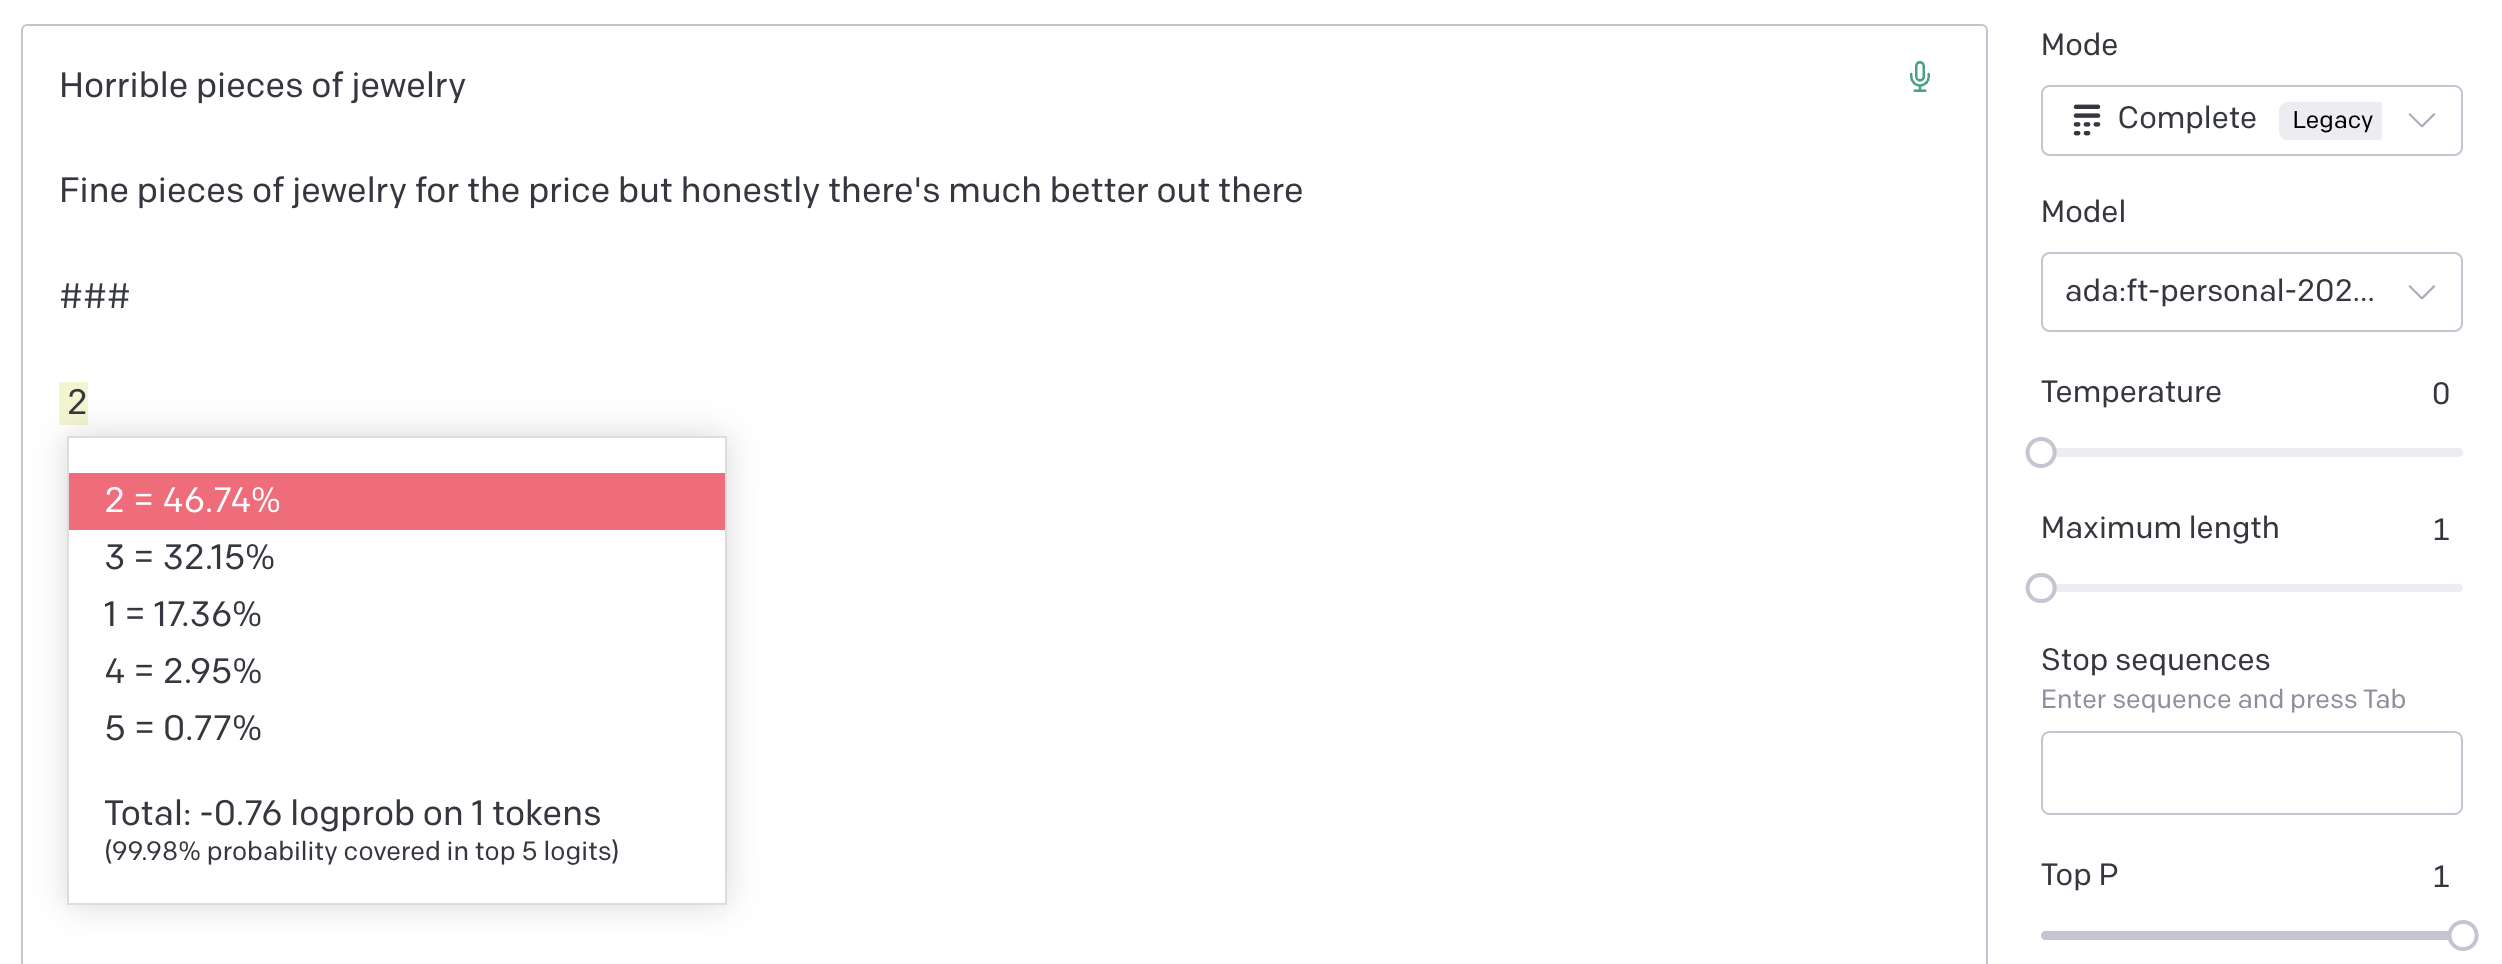

# Category Prediction

In [253]:
english_training_df[['review_title', 'review_body', 'language', 'stars', 'product_category']].sample(5)

review_title  \
217765              WORST CHARGER / DONT WASTE YOUR MONEY   
225554               Damaged parts might not be available   
320099                                    Love the chair!   
329229                      Need time for final judgement   
332033  These are very comfortable. The uppers are rea...   

                                              review_body language  stars  \
217765  Purchase the 4pk just in case and each one wor...       en      1   
225554  The overall quality is good. I received a dama...       en      1   
320099  250lbs of human in the chair has ripped the in...       en      4   
329229       Good looking, but not sure about the quality       en      4   
332033  I was looking for a slip on boat style shoe. T...       en      4   

       product_category  
217765         wireless  
225554        furniture  
320099           sports  
329229          apparel  
332033            shoes

In [7]:
training_df.shape

(1200000, 8)

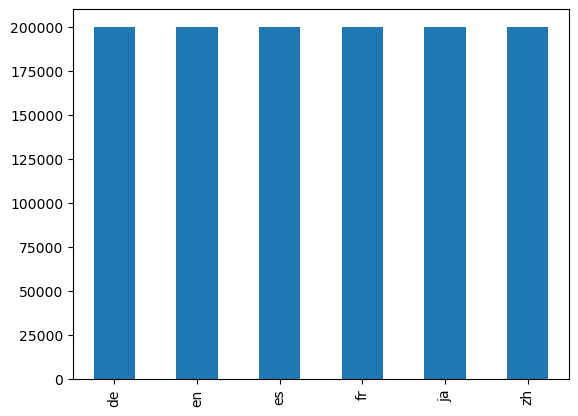

In [8]:
training_df['language'].value_counts().plot(kind='bar')

In [9]:
training_df['product_category'].nunique()

31

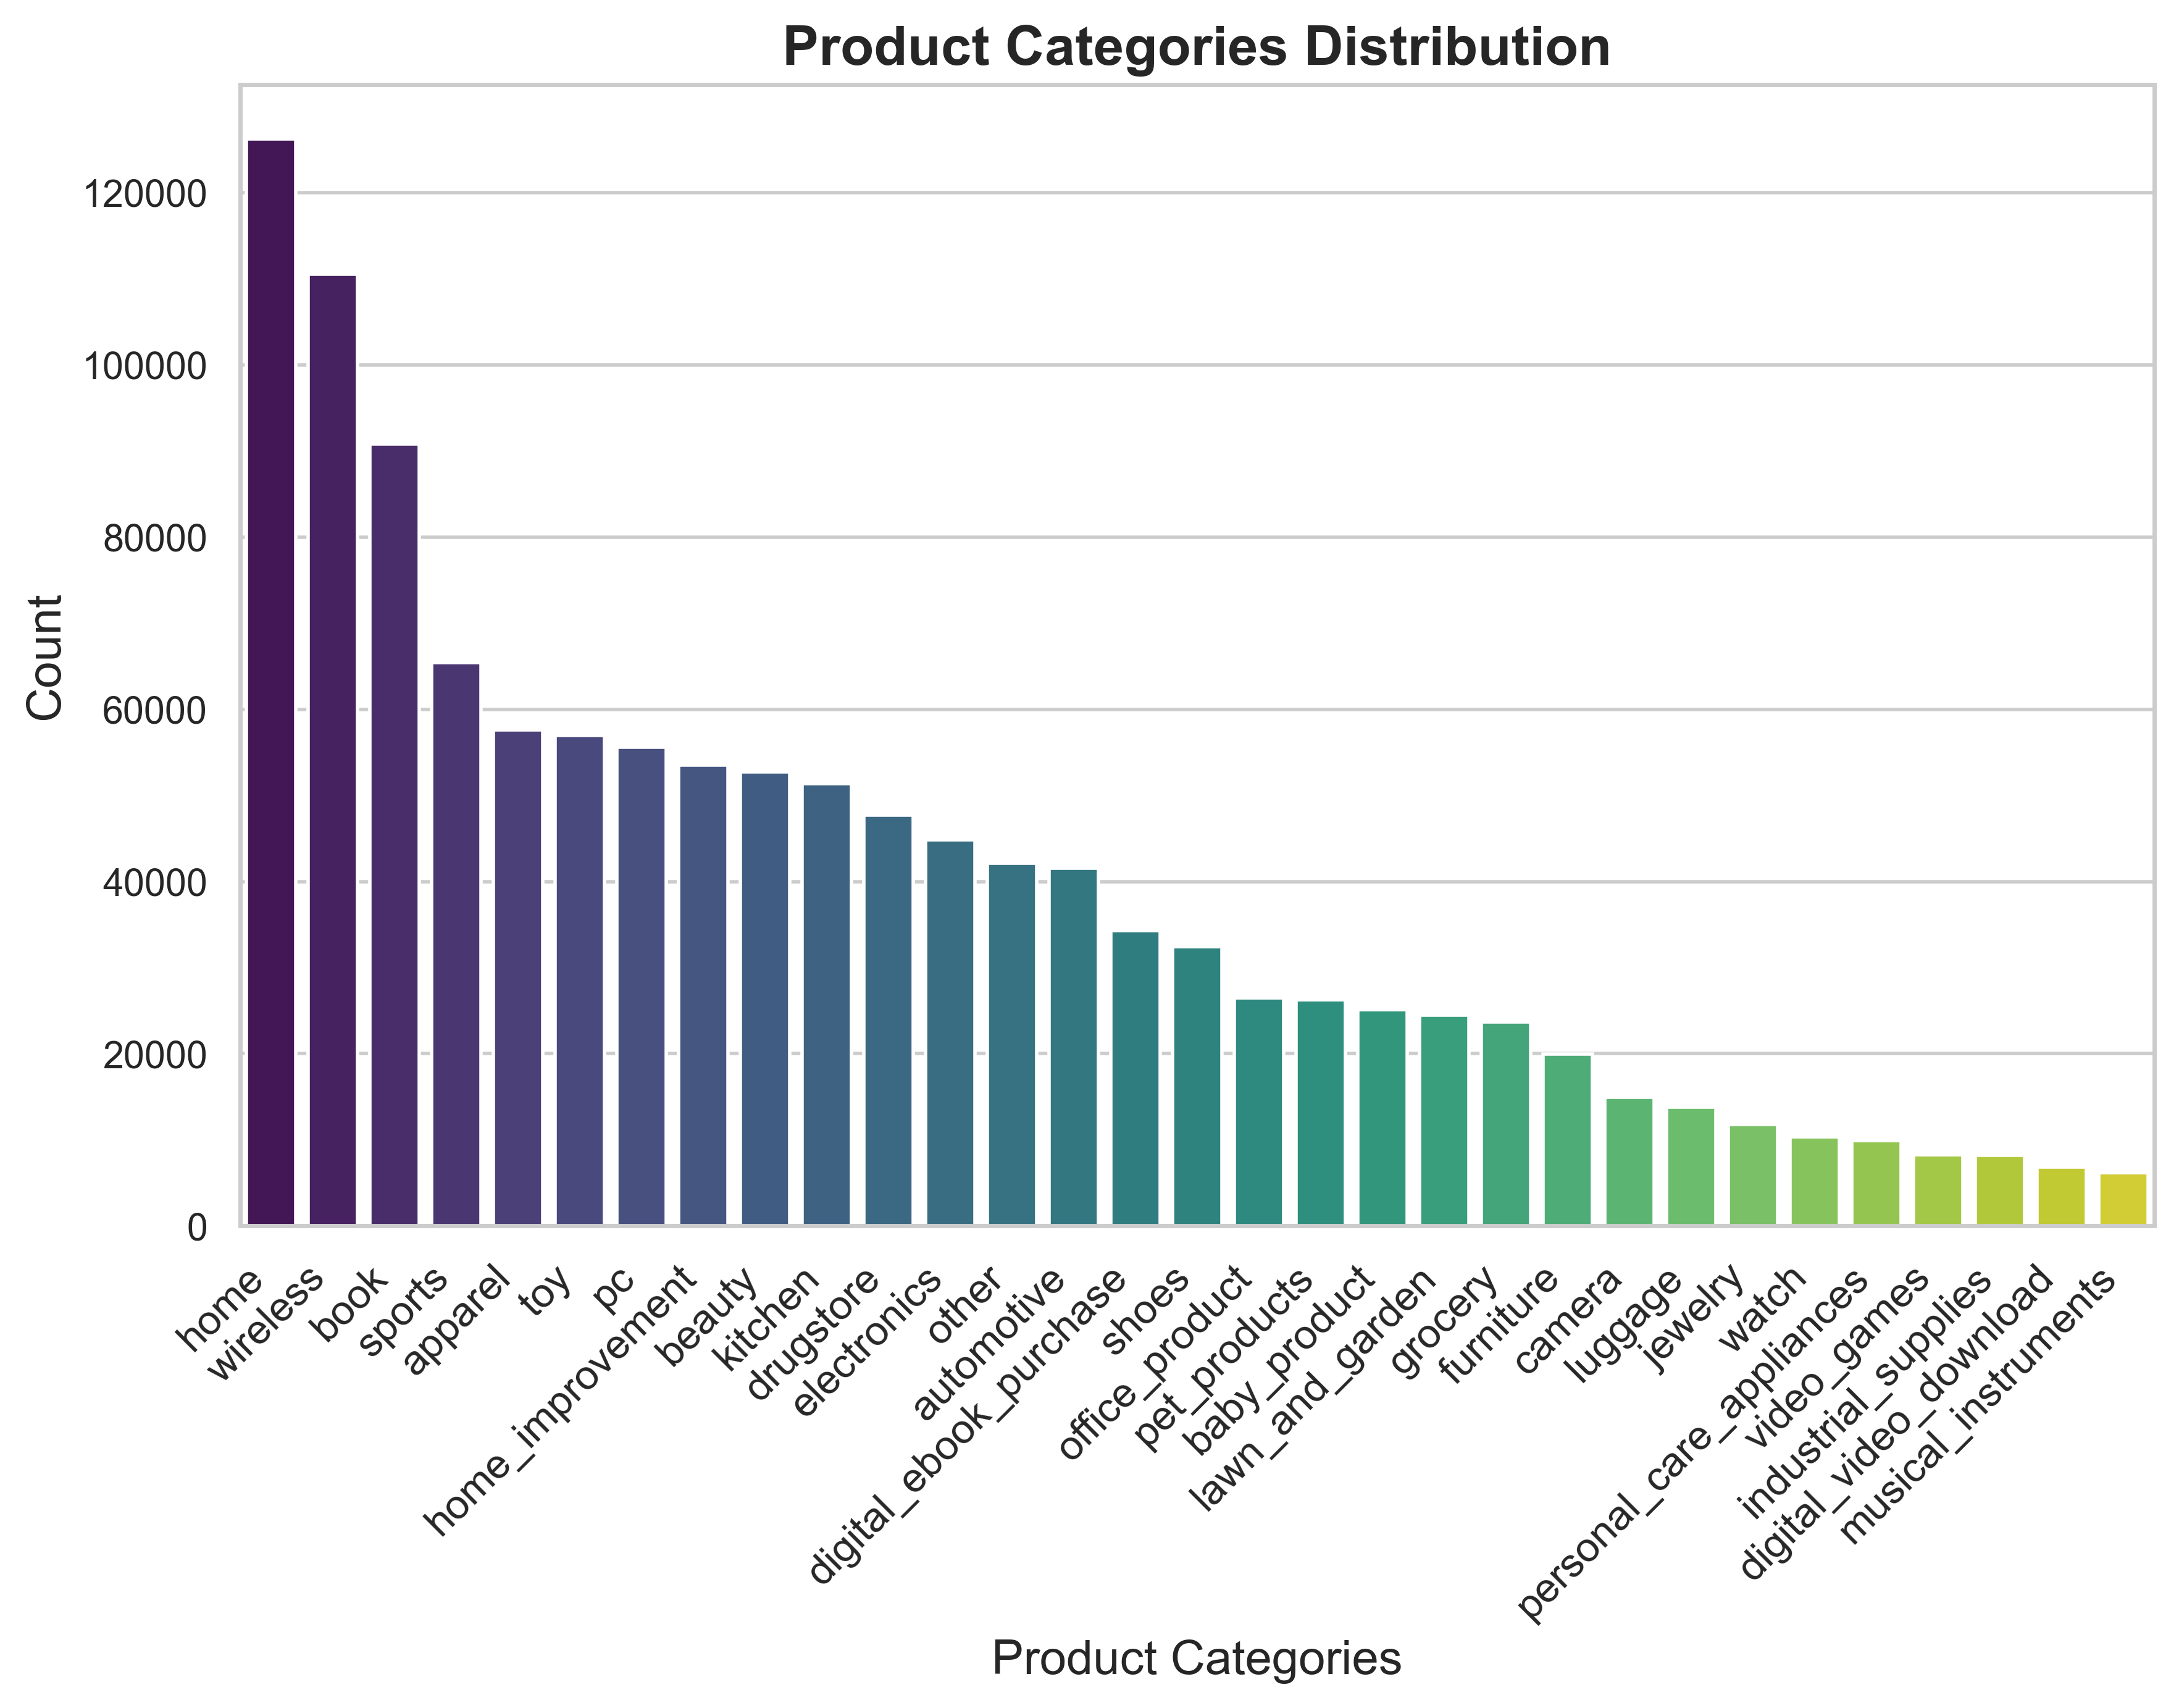

In [256]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the seaborn style
sns.set(style="whitegrid")

# Get the product category counts
category_counts = training_df['product_category'].value_counts()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6), dpi=400)

# Create the bar plot
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis", ax=ax)

# Customize the plot
ax.set_title('Product Categories Distribution', fontsize=16, fontweight='bold')
ax.set_xlabel('Product Categories', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=12)

# Show the plot
plt.show()


In [7]:
english_training_df = training_df[training_df['language'] == 'en']

In [12]:
def stratify_sample(df, sample_size, col='completion'):
    if col not in df:
        return f'col {col} not in df'

    # Calculate the proportion of each group in the 'completion' column
    group_proportions = df[col].value_counts(normalize=True)
    group_counts = dict(df[col].value_counts(normalize=False))

    # Calculate the number of samples to take from each group
    samples_per_group = (sample_size * group_proportions).round().astype(int)

    # Initialize an empty DataFrame for the stratified sample
    stratified_sample = pd.DataFrame()

    # Perform stratified sampling
    for group, n_samples in samples_per_group.items():
        # always get at least 10 examples
        group_sample = df[df[col] == group].sample(min(len(df[df[col] == group]), n_samples or group_counts[group]))
        stratified_sample = pd.concat([stratified_sample, group_sample])

    # Reset index of the stratified_sample DataFrame
    stratified_sample.reset_index(drop=True, inplace=True)

    return stratified_sample

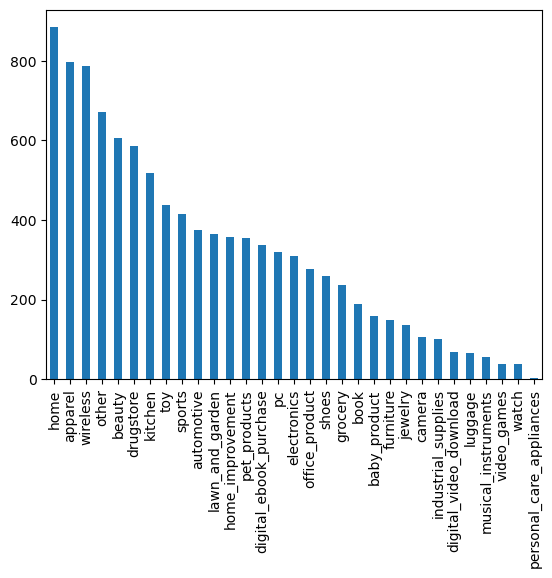

In [20]:
english_training_df_sample = stratify_sample(english_training_df, 10000, 'product_category')
english_training_df_sample['product_category'].value_counts().plot(kind='bar')

In [9]:
val_df = pd.DataFrame(dataset['validation'])
english_val_df = val_df[val_df['language'] == 'en']

english_val_df_sample = stratify_sample(english_val_df, 2000, 'product_category')
english_val_df_sample['product_category'].value_counts().plot(kind='bar')

NameError: name 'stratify_sample' is not defined

## Data Preparation
We transform the dataset to add a column for prompt and completion. The prompt contains the email from the mailing list, and the completion is a name of the sport, either hockey or baseball. For demonstration purposes only and speed of fine-tuning we take only 300 examples. In a real use case the more examples the better the performance.

In [24]:
import tiktoken
tokenizer = tiktoken.get_encoding("cl100k_base")
list(zip((' ' + training_df['product_category']).unique(), [tokenizer.encode(_) for _ in (' ' + ' ' + training_df['product_category']).unique()]))

from collections import Counter

def get_duplicates(lst):
    counts = Counter(lst)
    return [item for item, count in counts.items() if count > 1]

dupes = get_duplicates([tokenizer.encode(_)[0] for _ in ' ' + english_training_df_sample['product_category'].unique()])

dupes

[2162, 7528]

In [25]:
tokenizer.decode([2162, 7528])

' home digital'

In [109]:
def prepare_df_for_openai(df):
    df['prompt'] = df['review_title'] + '\n\n' + df['review_body'] + '\n\ncategory:'
    df['completion'] = ' ' + df['product_category']
    df['completion'] = df['completion'].map(lambda x: ' for_home' if x == ' home' else (' ebook_purchase' if x == ' digital_ebook_purchase'  else x))


In [27]:
prepare_df_for_openai(english_training_df_sample)
prepare_df_for_openai(english_val_df_sample)

In [287]:
i = 950

print(english_training_df_sample['prompt'][i])
print(english_training_df_sample['completion'][i])

Faded after first wash

My son asked for this shirt for Christmas, but the letters faded the first time I washed it, and I washed it on cold water!

category:
 apparel


# context is still key. No classifier would reasonably say "apparel"

In [282]:
i = 955
print(english_training_df_sample['prompt'][i])
print(english_training_df_sample['completion'][i])

One Star

Bad customer service never received the product had to ask for a refund

category:
 apparel


 for_home


In [28]:
english_training_df_sample[['prompt', 'completion']].to_json("amazon-sample-train.jsonl", orient='records', lines=True)
english_val_df_sample[['prompt', 'completion']].to_json("amazon-sample-val.jsonl", orient='records', lines=True)


### Data Preparation tool
We can now use a data preparation tool which will suggest a few improvements to our dataset before fine-tuning. Before launching the tool we update the openai library to ensure we're using the latest data preparation tool. We additionally specify `-q` which auto-accepts all suggestions.

In [265]:
!openai tools fine_tunes.prepare_data -f amazon-sample-train.jsonl

Analyzing...

- Your file contains 9999 prompt-completion pairs
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- All prompts end with suffix `\n\ncategory:`. This suffix seems very long. Consider replacing with a shorter suffix, such as `\n\n###\n\n`

No remediations found.
- [Recommended] Would you like to split into training and validation set? [Y/n]: ^C



The tool helpfully suggests a few improvements to the dataset and splits the dataset into training and validation set.

A suffix between a prompt and a completion is necessary to tell the model that the input text has stopped, and that it now needs to predict the class. Since we use the same separator in each example, the model is able to learn that it is meant to predict either baseball or hockey following the separator.
A whitespace prefix in completions is useful, as most word tokens are tokenized with a space prefix.
The tool also recognized that this is likely a classification task, so it suggested to split the dataset into training and validation datasets. This will allow us to easily measure expected performance on new data.

## Fine-tuning
The tool suggests we run the following command to train the dataset. Since this is a classification task, we would like to know what the generalization performance on the provided validation set is for our classification use case. The tool suggests to add `--compute_classification_metrics --classification_positive_class " baseball"` in order to compute the classification metrics.

We can simply copy the suggested command from the CLI tool. We specifically add `-m ada` to fine-tune a cheaper and faster ada model, which is usually comperable in performance to slower and more expensive models on classification use cases. 

## Sample of 10,000 English Training rows split up by OpenAI

We will use all languages in training and the provided validation set on ada

In [8]:
!openai api fine_tunes.create -t "amazon-sample-train.jsonl" -v "amazon-sample-val.jsonl" --compute_classification_metrics --classification_n_classes 31 -m ada


Found potentially duplicated files with name 'amazon-sample-train.jsonl', purpose 'fine-tune' and size 2644462 bytes
file-H0dPeplD4dTQicpevBE7DhGl
Enter file ID to reuse an already uploaded file, or an empty string to upload this file anyway: ^C



In [60]:
!openai api fine_tunes.follow -i ft-4BoKFxlrEQzVgh5uMQEErzFM

[2023-03-28 10:57:15] Created fine-tune: ft-4BoKFxlrEQzVgh5uMQEErzFM
[2023-03-28 13:09:18] Fine-tune costs $0.88
[2023-03-28 13:09:18] Fine-tune enqueued
[2023-03-28 14:02:00] Fine-tune is in the queue. Queue number: 31
[2023-03-28 14:02:30] Fine-tune is in the queue. Queue number: 30
[2023-03-28 14:03:13] Fine-tune is in the queue. Queue number: 29
[2023-03-28 14:05:26] Fine-tune is in the queue. Queue number: 28
[2023-03-28 14:06:20] Fine-tune is in the queue. Queue number: 27
[2023-03-28 14:06:23] Fine-tune is in the queue. Queue number: 26
[2023-03-28 14:08:48] Fine-tune is in the queue. Queue number: 25
[2023-03-28 14:09:32] Fine-tune is in the queue. Queue number: 24
[2023-03-28 14:10:26] Fine-tune is in the queue. Queue number: 23
[2023-03-28 14:10:59] Fine-tune is in the queue. Queue number: 22
[2023-03-28 14:11:00] Fine-tune is in the queue. Queue number: 21
[2023-03-28 14:13:06] Fine-tune is in the queue. Queue number: 20
[2023-03-28 14:23:40] Fine-tune is in the queue. Queue

In [191]:
!openai wandb sync -i ft-4BoKFxlrEQzVgh5uMQEErzFM


wandb: Currently logged in as: profoz. Use `wandb login --relogin` to force relogin
Fine-tune ft-4BoKFxlrEQzVgh5uMQEErzFM has already been logged successfully at https://wandb.ai/profoz/GPT-3/runs/ft-4BoKFxlrEQzVgh5uMQEErzFM
A new wandb run will be created for fine-tune ft-4BoKFxlrEQzVgh5uMQEErzFM and previous run will be overwritten
wandb: Tracking run with wandb version 0.14.0
wandb: Run data is saved locally in /Users/sinanozdemir/Teaching/Pearson/quick-start-llms/notebooks/wandb/run-20230329_083312-ft-4BoKFxlrEQzVgh5uMQEErzFM
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ft-4BoKFxlrEQzVgh5uMQEErzFM
wandb: ⭐️ View project at https://wandb.ai/profoz/GPT-3
wandb: 🚀 View run at https://wandb.ai/profoz/GPT-3/runs/ft-4BoKFxlrEQzVgh5uMQEErzFM
wandb: Waiting for W&B process to finish... (success).
wandb: 
wandb: Run history:
wandb:          classification/accuracy ▁▅█▆
wandb: classification/weighted_f1_score ▁▄█▇
wandb:                 elapsed_examples ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄

In [263]:
# Cancel a job
# !openai api fine_tunes.cancel -i ft-lz3FBn7n9TMDFqMGwUMvyjY6

[organization=user-9vr5p5naslsmcksivdeejxum] Error: Cannot cancel a job ft-lz3FBn7n9TMDFqMGwUMvyjY6 that already has status "cancelled". (HTTP status code: 400)


## All 200,000 English Training rows split up by OpenAI

We will use all languages in training and the provided validation set on ada

In [292]:
prepare_df_for_openai(english_training_df)
prepare_df_for_openai(english_val_df)

english_training_df[['prompt', 'completion']].to_json("amazon-english-full-train.jsonl", orient='records', lines=True)
english_val_df[['prompt', 'completion']].to_json("amazon-english-full-val.jsonl", orient='records', lines=True)


/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_32518/1351650422.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prompt'] = df['review_title'] + '\n\n' + df['review_body'] + '\n\ncategory:'
/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_32518/1351650422.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['completion'] = ' ' + df['product_category']
/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_32518/1351650422.py:4: SettingWithCopyWarning: 
A value is trying to

In [275]:
english_val_df

(5000, 10)

In [273]:
!openai tools fine_tunes.prepare_data -f amazon-train.jsonl

Analyzing...

- Your file contains 200000 prompt-completion pairs
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- There are 16 duplicated prompt-completion sets. These are rows: [27005, 92579, 104957, 111909, 137026, 139639, 143975, 151466, 152680, 157110, 179882, 183422, 192398, 193639, 196825, 197868]
- All prompts end with suffix `\n\ncategory:`. This suffix seems very long. Consider replacing with a shorter suffix, such as `\n\n###\n\n`

Based on the analysis we will perform the following actions:
- [Recommended] Remove 16 duplicate rows [Y/n]: ^C



In [ ]:
# ft-4BoKFxlrEQzVgh5uMQEErzFM == 10,000 stratified english from training and 2,000 from val for 4 epochs
# XXX% accuracy on holdout test set

# ft-aMkOUg4xyuO2nKyLCO7Gw8Iq == all 200,000 english from training split and 5,000 from val for 4 epochs
# 54.28% accuracy on holdout test set

# ft-DamviOlM8ngxYvO8eeqburFX == a further 4 epochs on all 200,000 english from training split and 5,000 from val
# 52.42% accuracy on holdout test set

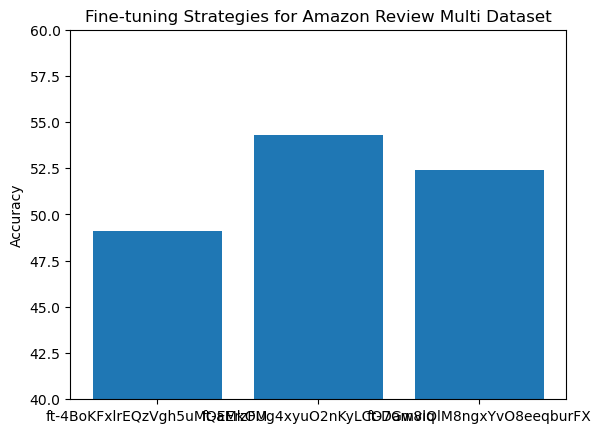

In [138]:
import matplotlib.pyplot as plt

# Data
x_labels = ['ft-4BoKFxlrEQzVgh5uMQEErzFM', 'ft-aMkOUg4xyuO2nKyLCO7Gw8Iq', 'ft-DamviOlM8ngxYvO8eeqburFX']
y_values = [49.08, 54.28, 52.42]

# Plotting
plt.bar(x_labels, y_values)
plt.ylim(40,60)
plt.ylabel('Accuracy')
plt.title('Fine-tuning Strategies for Amazon Review Multi Dataset')

# Displaying
plt.show()

In [278]:
!openai api fine_tunes.create -t "amazon-english-full-train.jsonl" -v "amazon-english-full-val.jsonl" --compute_classification_metrics --classification_n_classes 31 -m ada


Upload progress: 100%|████████████████████| 52.2M/52.2M [00:00<00:00, 23.6Git/s]
Uploaded file from amazon-english-full-train.jsonl: file-nKmunSONblx0k8kPYglJ9t7u
Upload progress: 100%|█████████████████████| 1.32M/1.32M [00:00<00:00, 495Mit/s]
Uploaded file from amazon-english-full-val.jsonl: file-sYqp2Tz7JfCzy9JPKcHy5dfS
Created fine-tune: ft-EMSPfhqQism2LFSajvAXKXS3
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2023-03-28 11:00:45] Created fine-tune: ft-EMSPfhqQism2LFSajvAXKXS3

Stream interrupted (client disconnected).
To resume the stream, run:

  openai api fine_tunes.follow -i ft-EMSPfhqQism2LFSajvAXKXS3



In [59]:
!openai api fine_tunes.follow -i ft-EMSPfhqQism2LFSajvAXKXS3

[2023-03-28 11:00:45] Created fine-tune: ft-EMSPfhqQism2LFSajvAXKXS3
[2023-03-28 15:21:10] Fine-tune costs $17.32
[2023-03-28 15:21:10] Fine-tune enqueued
[2023-03-28 16:30:24] Fine-tune is in the queue. Queue number: 31
[2023-03-28 16:30:37] Fine-tune is in the queue. Queue number: 30
[2023-03-28 16:30:58] Fine-tune is in the queue. Queue number: 29
[2023-03-28 16:31:12] Fine-tune is in the queue. Queue number: 28
[2023-03-28 16:31:18] Fine-tune is in the queue. Queue number: 27
[2023-03-28 16:31:46] Fine-tune is in the queue. Queue number: 26
[2023-03-28 16:32:40] Fine-tune is in the queue. Queue number: 25
[2023-03-28 16:32:43] Fine-tune is in the queue. Queue number: 24
[2023-03-28 16:33:56] Fine-tune is in the queue. Queue number: 23
[2023-03-28 16:35:00] Fine-tune is in the queue. Queue number: 22
[2023-03-28 16:35:54] Fine-tune is in the queue. Queue number: 21
[2023-03-28 16:35:57] Fine-tune is in the queue. Queue number: 20
[2023-03-28 16:37:45] Fine-tune is in the queue. Queu

In [ ]:
# TODO test it on testing set and compare to Random Forest

In [17]:
# Cancel a job
# !openai api fine_tunes.cancel -i ft-EMSPfhqQism2LFSajvAXKXS3

## All 1,200,000 training rows and 30,000 validation rows (all languages)

We will use all languages in training and the provided validation set on ada

In [111]:
df = pd.DataFrame(dataset['train'])

df['prompt'] = df['review_title'] + '\n\n' + df['review_body'] + '\n\ncategory:'
df['completion'] = ' ' + df['product_category']
df['completion'] = df['completion'].map(lambda x: ' for_home' if x == ' home' else (' ebook_purchase' if x == ' digital_ebook_purchase'  else x))

df[['prompt', 'completion']].to_json("amazon-train-full-multi.jsonl", orient='records', lines=True)


In [112]:
df.shape

(1200000, 10)

In [113]:
df = pd.DataFrame(dataset['validation'])

df['prompt'] = df['review_title'] + '\n\n' + df['review_body'] + '\n\ncategory:'
df['completion'] = ' ' + df['product_category']
df['completion'] = df['completion'].map(lambda x: ' for_home' if x == ' home' else (' ebook_purchase' if x == ' digital_ebook_purchase'  else x))

df[['prompt', 'completion']].to_json("amazon-val-full-multi.jsonl", orient='records', lines=True)


In [114]:
df['completion'].nunique()  # sanity check that we still have 31 categories

31

In [115]:
df.shape

(30000, 10)

In [ ]:
# !openai api fine_tunes.create -t "amazon-train-full.jsonl" -v "amazon-val-full.jsonl" --compute_classification_metrics --classification_n_classes 31 -m ada


The model is successfully trained in about ten minutes. We can see the model name is `ada:ft-openai-2021-07-30-12-26-20`, which we can use for doing inference.

### [Advanced] Results and expected model performance
We can now download the results file to observe the expected performance on a held out validation set.

In [77]:
!openai wandb sync -i ft-EMSPfhqQism2LFSajvAXKXS3


wandb: Currently logged in as: profoz. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.14.0
wandb: Run data is saved locally in /Users/sinanozdemir/Teaching/Pearson/quick-start-llms/notebooks/wandb/run-20230329_054616-ft-EMSPfhqQism2LFSajvAXKXS3
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ft-EMSPfhqQism2LFSajvAXKXS3
wandb: ⭐️ View project at https://wandb.ai/profoz/GPT-3
wandb: 🚀 View run at https://wandb.ai/profoz/GPT-3/runs/ft-EMSPfhqQism2LFSajvAXKXS3
wandb: Waiting for W&B process to finish... (success).
wandb: 
wandb: Run history:
wandb:          classification/accuracy ▁█▇▆
wandb: classification/weighted_f1_score ▁▇█▇
wandb:                 elapsed_examples ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                   elapsed_tokens ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                    training_loss █▆▄▅▅▆▆▆▅▅▅▅▅▃▄▅▆▄▂▂▅▇▆▂▅▃▄▃▄▃▃▅▄▃▂▂▃▂▁▅
wandb:       training_sequence_accuracy ▁▂▂▄▅▃▃▄▄▃▃▃▄▅▄▅▅▅▅▃▃▄▆▄▅

In [78]:
!openai api fine_tunes.results -i ft-EMSPfhqQism2LFSajvAXKXS3 > result.csv

In [79]:
results = pd.read_csv('result.csv')
results[results['classification/accuracy'].notnull()].tail(3)

step  elapsed_tokens  elapsed_examples  training_loss  \
1563  1564       129866752            400384       0.013091   
2345  2346       194341376            600576       0.010413   
3125  3126       259177984            800256       0.004740   

      training_sequence_accuracy  training_token_accuracy  validation_loss  \
1563                    0.511719                 0.738189              NaN   
2345                    0.531250                 0.719486              NaN   
3125                    0.593750                 0.759382              NaN   

      validation_sequence_accuracy  validation_token_accuracy  \
1563                           NaN                        NaN   
2345                           NaN                        NaN   
3125                           NaN                        NaN   

      classification/accuracy  classification/weighted_f1_score  
1563                   0.5400                          0.530703  
2345                   0.5384                          0.531564  
3125                   0.5348                          0.530450

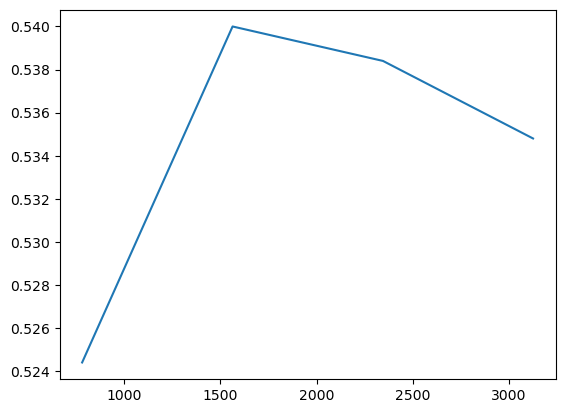

In [80]:
results[results['classification/accuracy'].notnull()]['classification/accuracy'].plot()

## Using the model
We can now call the model to get the predictions.

In [110]:
test_df = pd.DataFrame(dataset['test'])
english_test_df = test_df[test_df['language'] == 'en']
prepare_df_for_openai(english_test_df)


/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_48452/1351650422.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prompt'] = df['review_title'] + '\n\n' + df['review_body'] + '\n\ncategory:'
/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_48452/1351650422.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['completion'] = ' ' + df['product_category']
/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_48452/1351650422.py:4: SettingWithCopyWarning: 
A value is trying to

In [111]:
english_test_df.head()

review_id          product_id          reviewer_id  stars  \
5000  en_0199937  product_en_0902516  reviewer_en_0097389      1   
5001  en_0863335  product_en_0348072  reviewer_en_0601537      1   
5002  en_0565010  product_en_0356154  reviewer_en_0970351      1   
5003  en_0963290  product_en_0583322  reviewer_en_0216125      1   
5004  en_0238156  product_en_0487636  reviewer_en_0514203      1   

                                            review_body  \
5000  These are AWFUL. They are see through, the fab...   
5001  I bought 4 and NONE of them worked. Yes I used...   
5002  On first use it didn't heat up and now it does...   
5003  You want an HONEST answer? I just returned fro...   
5004  The glue works fine but the container is impos...   

                review_title language     product_category  \
5000  Don’t waste your time!       en              apparel   
5001                One Star       en                other   
5002         Totally useless       en                other   
5003    Gold filled earrings       en              jewelry   
5004          Poor container       en  industrial_supplies   

                                                 prompt            completion  
5000  Don’t waste your time!\n\nThese are AWFUL. The...               apparel  
5001  One Star\n\nI bought 4 and NONE of them worked...                 other  
5002  Totally useless\n\nOn first use it didn't heat...                 other  
5003  Gold filled earrings\n\nYou want an HONEST ans...               jewelry  
5004  Poor container\n\nThe glue works fine but the ...   industrial_supplies

We need to use the same separator following the prompt which we used during fine-tuning. In this case it is `\n\n###\n\n`. Since we're concerned with classification, we want the temperature to be as low as possible, and we only require one token completion to determine the prediction of the model.

To get the log probabilities, we can specify logprobs parameter on the completion request

In [197]:
finetuned_model = 'ada:ft-personal-2023-03-29-01-56-10'
res = openai.Completion.create(
    model=finetuned_model, 
    prompt=english_test_df['prompt'].iloc[0], 
    max_tokens=10, 
    temperature=0, 
    logprobs=2
)
res['choices'][0]['logprobs']['top_logprobs'][0], res['choices'][0].text

(<OpenAIObject at 0x2e71d42c0> JSON: {
   " apparel": -0.058649287,
   " for": -3.7051516
 },
 ' apparel_couture_brands_category')

In [288]:
category_comma_split = ", ".join(training_df["product_category"].unique())
category_comma_split

'sports, home_improvement, drugstore, toy, baby_product, lawn_and_garden, electronics, book, home, wireless, pc, shoes, automotive, furniture, beauty, digital_ebook_purchase, kitchen, personal_care_appliances, office_product, apparel, video_games, pet_products, digital_video_download, musical_instruments, other, watch, luggage, jewelry, camera, industrial_supplies, grocery'

In [283]:
def classify(prompt, model, answer=None):
    res = openai.Completion.create(
        model=model, 
        prompt=prompt,
        max_tokens=1, 
        temperature=0, 
        logprobs=5,
    )
    probs = []
    logprobs = res['choices'][0]['logprobs']['top_logprobs']
    for logprob in logprobs:
        _probs = {}
        for key, value in logprob.items():
            _probs[key] = math.exp(value)

        probs.append(_probs)
    pred = res['choices'][0].text.strip()
    if answer:
        correct = answer.strip().startswith(pred)
    else:
        correct = None
    return pred, answer, correct, probs

i = 0
classify(english_test_df['prompt'].iloc[i], 'ada:ft-personal-2023-03-29-01-56-10', english_test_df['product_category'].iloc[i])


('category',
 'apparel',
 False,
 [{'category': 0.15231893497300433,
   ' for': 0.04855897210401139,
   ' apparel': 0.06613382092293602,
   ' baby': 0.023380203943184952,
   ' $': 0.020964096393578654}])

In [100]:
sampled_english_test_df = english_test_df.sample(5000)


In [134]:
correct = 0
preds = []

for i in tqdm(range(sampled_english_test_df.shape[0])):
    _pred, _answer, _correct, _probs = classify(
        sampled_english_test_df['prompt'].iloc[i], 
        'ada:ft-personal-2023-03-28-22-20-55', 
        sampled_english_test_df['completion'].iloc[i]
    )
    correct += _correct
    preds.append(_pred)
accuracy = correct / ( i + 1 )
accuracy

100%|██████████████████████████████████████████████████████████████████████| 5000/5000 [12:10<00:00,  6.84it/s]


0.4908

In [234]:
correct = 0
preds = []

for i in tqdm(range(sampled_english_test_df.shape[0])):
    _pred, _answer, _correct, _probs = classify(
        sampled_english_test_df['prompt'].iloc[i], 
        'ada:ft-personal-2023-03-29-01-56-10', 
        sampled_english_test_df['completion'].iloc[i]
    )
    correct += _correct
    preds.append(_pred)
accuracy = correct / ( i + 1 )
accuracy

100%|██████████████████████████████████████████████████████████████████████| 5000/5000 [14:33<00:00,  5.73it/s]


0.5428

In [215]:
# correct = 0
# preds = []

# # for i in tqdm(range(test_df.shape[0])):
# for i in tqdm(range(3)):
#     _pred, _answer, _correct, _probs = classify(
#         english_test_df['prompt'].iloc[i], 'gpt-3.5-turbo', english_test_df['completion'].iloc[i]
#     )
#     correct += _correct
#     preds.append(_pred)
# accuracy = correct / ( i + 1 )
# accuracy

100%|████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.65it/s]


0.3333333333333333

# Incremental Training, training the full English model for another 4 epochs

In [85]:
!openai api fine_tunes.create -t "file-nKmunSONblx0k8kPYglJ9t7u" -v "file-sYqp2Tz7JfCzy9JPKcHy5dfS" --compute_classification_metrics --classification_n_classes 31 -m ada:ft-personal-2023-03-29-01-56-10
    

Created fine-tune: ft-DamviOlM8ngxYvO8eeqburFX
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2023-03-29 05:49:46] Created fine-tune: ft-DamviOlM8ngxYvO8eeqburFX

Stream interrupted (client disconnected).
To resume the stream, run:

  openai api fine_tunes.follow -i ft-DamviOlM8ngxYvO8eeqburFX



In [185]:
!openai api fine_tunes.follow -i ft-DamviOlM8ngxYvO8eeqburFX

[2023-03-29 05:49:46] Created fine-tune: ft-DamviOlM8ngxYvO8eeqburFX
[2023-03-29 05:53:43] Fine-tune costs $17.32
[2023-03-29 05:53:43] Fine-tune enqueued. Queue number: 0
[2023-03-29 06:01:46] Fine-tune started
[2023-03-29 06:25:36] Completed epoch 1/4
[2023-03-29 06:51:25] Completed epoch 2/4
[2023-03-29 07:17:04] Completed epoch 3/4
[2023-03-29 07:42:50] Completed epoch 4/4
[2023-03-29 07:45:33] Uploaded model: ada:ft-personal-2023-03-29-14-45-33
[2023-03-29 07:45:34] Uploaded result file: file-57BeeHG3Z4KTzYiKhrcubeDy
[2023-03-29 07:45:34] Fine-tune succeeded

Job complete! Status: succeeded 🎉
Try out your fine-tuned model:

openai api completions.create -m ada:ft-personal-2023-03-29-14-45-33 -p <YOUR_PROMPT>


In [186]:
!openai wandb sync -i ft-DamviOlM8ngxYvO8eeqburFX


wandb: Currently logged in as: profoz. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.14.0
wandb: Run data is saved locally in /Users/sinanozdemir/Teaching/Pearson/quick-start-llms/notebooks/wandb/run-20230329_082741-ft-DamviOlM8ngxYvO8eeqburFX
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ft-DamviOlM8ngxYvO8eeqburFX
wandb: ⭐️ View project at https://wandb.ai/profoz/GPT-3
wandb: 🚀 View run at https://wandb.ai/profoz/GPT-3/runs/ft-DamviOlM8ngxYvO8eeqburFX
wandb: Waiting for W&B process to finish... (success).
wandb: 
wandb: Run history:
wandb:          classification/accuracy █▆▁▆
wandb: classification/weighted_f1_score ▅█▁▆
wandb:                 elapsed_examples ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                   elapsed_tokens ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                    training_loss ▅▄▄█▆▃▃▅█▄▇▆▅▅▅▅▄▅▄▂▅▄▄▇▄▁▅▃▅▃▅▅▃▃▃▁▃▃▂▅
wandb:       training_sequence_accuracy ▃▂▄▃▄▄▃▃▁▃▂▂▄▄▄▄▄▄▂▃▄▃▅▆▆

In [235]:
correct, preds = 0, []
for i in tqdm(range(sampled_english_test_df.shape[0])):
    _pred, _answer, _correct, _probs = classify(
        sampled_english_test_df['prompt'].iloc[i], 
        'ada:ft-personal-2023-03-29-14-45-33', 
        sampled_english_test_df['completion'].iloc[i]
    )
    correct += _correct
    preds.append(_pred)
accuracy = correct / ( i + 1 )
accuracy

100%|██████████████████████████████████████████████████████████████████████| 5000/5000 [11:04<00:00,  7.52it/s]


0.5242

In [ ]:
# compare each model to proper validation (maybe sample to speed things up)
# compare price to davinci or chatgpt, gpt-4
# Also try a random forest with embeddings?
# Also try randomforfeset plus tfidf?
# also try random forest with open source embedder

In [217]:
training_texts_for_ml = english_training_df['review_title'] + ' ' + english_training_df['review_body']
val_texts_for_ml = english_val_df['review_title'] + ' ' + english_val_df['review_body']
test_texts_for_ml = english_test_df['review_title'] + ' ' + english_val_df['review_body']

In [46]:
from tqdm import tqdm
from openai.embeddings_utils import get_embeddings

ENGINE = 'text-embedding-ada-002'

def openai_embed(texts, n):

    embeddings = None
    for s in tqdm(range(0, len(texts), n)):
        if embeddings is None:
            embeddings = np.array(get_embeddings(texts[s:s+n], engine=ENGINE))
        else:
            embeddings = np.vstack([embeddings, np.array(get_embeddings(texts[s:s+n], engine=ENGINE))])
    return embeddings


In [47]:
training_embeddings = openai_embed(training_texts_for_ml, 1000)

  0%|                                                                                  | 0/200 [00:00<?, ?it/s]/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_32518/2535785194.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  embeddings = np.array(get_embeddings(texts[s:s+n], engine=ENGINE))
  0%|▎                                                                         | 1/200 [00:04<14:53,  4.49s/it]/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_32518/2535785194.py:13: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.il

In [49]:
val_embeddings = openai_embed(val_texts_for_ml, 1000)

  0%|                                                                                    | 0/5 [00:00<?, ?it/s]/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_32518/2535785194.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  embeddings = np.array(get_embeddings(texts[s:s+n], engine=ENGINE))
 20%|███████████████▏                                                            | 1/5 [00:06<00:25,  6.40s/it]/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_32518/2535785194.py:13: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.il

In [218]:
test_embeddings = openai_embed(test_texts_for_ml, 1000)

  0%|                                                                                    | 0/5 [00:00<?, ?it/s]/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_32518/2535785194.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  embeddings = np.array(get_embeddings(texts[s:s+n], engine=ENGINE))
 20%|███████████████▏                                                            | 1/5 [00:03<00:13,  3.37s/it]/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_32518/2535785194.py:13: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.il

In [51]:
# Save the numpy embeddings to disk
np.save('training_embeddings.npy', training_embeddings)
np.save('val_embeddings.npy', val_embeddings)
np.save('test_embeddings.npy', test_embeddings)

# Load the numpy embeddings from disk
# training_embeddings = np.load('training_embeddings.npy')
# val_embeddings = np.load('val_embeddings.npy')
# test_embeddings = np.load('test_embeddings.npy')


In [ ]:
max_depth=None
min_samples_leaf=1
min_samples_split=5
n_estimators=200

In [236]:
# train random forest classifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Define the hyperparameters to test
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None],
    'min_samples_split': [2, 5]
}
param_grid = {
    'n_estimators': [200],
    'max_depth': [None],
    'min_samples_split': [5]
}

# Create the model
clf = RandomForestClassifier()

# Define the grid search
grid_search = GridSearchCV(clf, param_grid, cv=3, verbose=10)

# Fit the grid search to the data
grid_search.fit(training_embeddings, english_training_df['completion'])

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START max_depth=None, min_samples_split=5, n_estimators=200.......
[CV 1/3; 1/1] END max_depth=None, min_samples_split=5, n_estimators=200;, score=0.409 total time=21.4min
[CV 2/3; 1/1] START max_depth=None, min_samples_split=5, n_estimators=200.......
[CV 2/3; 1/1] END max_depth=None, min_samples_split=5, n_estimators=200;, score=0.447 total time=21.7min
[CV 3/3; 1/1] START max_depth=None, min_samples_split=5, n_estimators=200.......
[CV 3/3; 1/1] END max_depth=None, min_samples_split=5, n_estimators=200;, score=0.459 total time=22.7min


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None], 'min_samples_split': [5],
                         'n_estimators': [200]},
             verbose=10)

In [237]:
# Get the best model
best_model = grid_search.best_estimator_

# Predict the target variable
preds = best_model.predict(test_embeddings)

# Print the classification report
report = classification_report(english_val_df['completion'], preds)
print(report)


                           precision    recall  f1-score   support

                  apparel       0.49      0.74      0.59       401
               automotive       0.47      0.37      0.41       178
             baby_product       1.00      0.01      0.03        75
                   beauty       0.51      0.56      0.54       344
                     book       0.61      0.27      0.37        82
                   camera       0.33      0.02      0.04        52
   digital_video_download       0.92      0.27      0.41        45
                drugstore       0.38      0.28      0.32       316
           ebook_purchase       0.69      0.88      0.77       149
              electronics       0.39      0.19      0.25       182
                 for_home       0.20      0.59      0.30       390
                furniture       0.88      0.12      0.21        59
                  grocery       0.64      0.51      0.57       105
         home_improvement       0.49      0.24      0.33     

/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
